In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
import h5py 

# Setup importing form this package
doc = mp.jupyter.open_source_package()
doc.set_sys_path()
import pylib # Import the code for the package

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [2]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()

ntl_p = pkg.reference('ntl').package
sez = pkg.reference('sez').resource.geoframe()
sez.head()

,id,unique_id,check,latitude,longitude,country_code,country_type_combo,region,country,zone_type,...,populous_citydist,city_1m,city_1mdist,city_500k,city_500kdist,500kcity_range,city_300k,city_300kdist,note,geometry
0,0,URY12,URY,-33.887443,-58.416899,URY,URYFree Zone,LAC,Uruguay,Free Zone,...,265,Montevideo,265,Montevideo,265,50 to 299 km,Montevideo,265,NaN,POINT (-58.41690 -33.88744)
1,1,URY2,URY,-34.470636,-57.831424,URY,URYFree Zone,LAC,Uruguay,Free Zone,...,182,Montevideo,182,Montevideo,182,50 to 299 km,Montevideo,182,NaN,POINT (-57.83142 -34.47064)
2,2,COL2,COL,10.960451,-74.762902,COL,COLFree Industrial Zone,LAC,Colombia,Free Industrial Zone,...,1013,Barranquilla,6,Barranquilla,6,Less than 50 km,Barranquilla,6,NaN,POINT (-74.76290 10.96045)
3,3,GUY3,GUY,6.791794,-58.167016,GUY,GUYIndustrial Estate,LAC,Guyana,Industrial Estate,...,4,No city in country with population greater tha...,0,No city in country with population greater tha...,0,Less than 50 km,No city in country with population greater tha...,0,The Government has noted that existing industr...,POINT (-58.16702 6.79179)
4,4,IND186,IND,23.034146,70.127156,IND,INDSpecial Economic Zone,SA,India,Special Economic Zone,...,830,Rajkot,191,Morbi,191,50 to 299 km,Morbi,191,NaN,POINT (70.12716 23.03415)


<AxesSubplot:>

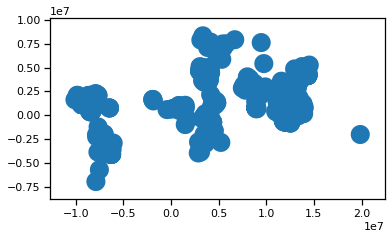

In [3]:
# The operational date col is a string, so make an int year column. 
sez['year'] = pd.to_numeric(sez.operational_date, errors='coerce')

sez.to_crs(3395).buffer(1000000).plot()



In [4]:
# Generate all of the patches by masking each of the geometries in sez onto 
# all of the rasters in the ntl_p package. 


def build_buffer_files(df):
    files = {}

    for radius in (5_000, 10_000):

        sez = df.copy()
        
        sez_rings, rings, rings_exc, ring_sums = pylib.build_ring_sums(ntl_p, sez, radius=radius)
        
        # Need to buffer in meters, and calc area in meters. 
        
        g =  sez.to_crs(3395).buffer(radius)

        sez['geo_area'] = g.area
        sez['geometry'] = g.to_crs(4326)
        buffers, buffer_exc, tasks = pylib.mp_ntl_mask(ntl_p, sez, desc=f'buffer {radius}')

        buffer_sums = pd.DataFrame([ (e[0],e[1], np.nansum(e[2]), np.count_nonzero(~np.isnan(e[2]))) 
                                     for e in buffers ],
                           columns=['year','unique_id','buffer_pix_sum', 'buffer_pix_count'])
        
        sums = buffer_sums\
                .merge(ring_sums, on=['year','unique_id'])\
                .merge(sez[['unique_id', 'geo_area']])\
                .merge(sez_rings[['unique_id','ring_area']])\
                .rename(columns={'geo_area':'buffer_area'})
        
        sums['radius'] = radius
        
        files[radius] = {
            'df_buffers': sez,
            'df_rings': sez_rings,
            'buffers': buffers,
            'rings': rings,
            'buffers_ex': buffer_exc,
            'rings_ex': rings_exc,
            'sums': sums,
            'buffer_sums': buffer_sums,
            'ring_sums': ring_sums

        }
        
    return files
      
bufs  = build_buffer_files(sez)


ring ring 5000:   0%|          | 0/15768 [00:00<?, ?it/s]

geometry buffer 5000:   0%|          | 0/15768 [00:00<?, ?it/s]

ring ring 10000:   0%|          | 0/15768 [00:00<?, ?it/s]

geometry buffer 10000:   0%|          | 0/15768 [00:00<?, ?it/s]

In [5]:
df = pd.concat([e['sums'] for e in bufs.values()])
df.to_csv('../data/mean_lights.csv', index=False)
df.head()

,year,unique_id,buffer_pix_sum,buffer_pix_count,ring_pix_sum,ring_pix_count,buffer_area,ring_area,radius
0,1992,URY12,346,110,109,238,7.841371e+07,7.841371e+07,5000
1,1993,URY12,753,110,158,238,7.841371e+07,7.841371e+07,5000
2,1994,URY12,748,110,180,238,7.841371e+07,7.841371e+07,5000
3,1995,URY12,969,110,140,238,7.841371e+07,7.841371e+07,5000
4,1996,URY12,1076,110,169,238,7.841371e+07,7.841371e+07,5000


In [6]:
sez.unique_id.nunique(), df.unique_id.nunique(), bufs[5000]['df_buffers'].unique_id.nunique(),  \
bufs[5000]['buffer_sums'].unique_id.nunique()

(584, 584, 584, 584)

In [7]:
# Write patches into an HDF file"""

with h5py.File('../data/sez_patches.h5', 'w') as f:
    for radius, e in bufs.items():
        for year, sez_id,  patch in e['buffers']:
            f[f'{radius}/buffer/{sez_id}/{year}'] = patch
        for year, sez_id,  patch in e['rings']:
            f[f'{radius}/rings/{sez_id}/{year}'] = patch


In [8]:

t = df[['radius', 'buffer_area','ring_area']].round(-3).drop_duplicates()
t['adiff'] = t.buffer_area - t.ring_area
assert t.adiff.sum() == 0

In [9]:
df

,year,unique_id,buffer_pix_sum,buffer_pix_count,ring_pix_sum,ring_pix_count,buffer_area,ring_area,radius
0,1992,URY12,346,110,109,238,7.841371e+07,7.841371e+07,5000
1,1993,URY12,753,110,158,238,7.841371e+07,7.841371e+07,5000
2,1994,URY12,748,110,180,238,7.841371e+07,7.841371e+07,5000
3,1995,URY12,969,110,140,238,7.841371e+07,7.841371e+07,5000
4,1996,URY12,1076,110,169,238,7.841371e+07,7.841371e+07,5000
...,...,...,...,...,...,...,...,...,...
15763,2014,CMR5,2200,506,937,992,3.136548e+08,3.136548e+08,10000
15764,2015,CMR5,2507,506,1163,992,3.136548e+08,3.136548e+08,10000
15765,2016,CMR5,2370,506,634,992,3.136548e+08,3.136548e+08,10000
15766,2017,CMR5,3350,506,2002,992,3.136548e+08,3.136548e+08,10000


<AxesSubplot:>

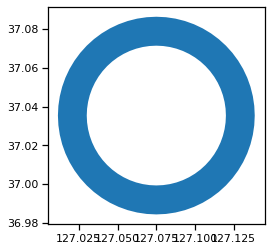

In [29]:
t = bufs[5000]['df_rings']
kor_uids = ['KOR103']
t = t[t.unique_id.isin(kor_uids)]
t.ring.plot()

In [28]:
t.columns

Index(['id', 'unique_id', 'check', 'latitude', 'longitude', 'country_code',
       'country_type_combo', 'region', 'country', 'zone_type', 'zone_name',
       'operational_date', 'size', 'management_type', 'management_company',
       'legal_framework', 'legalframework_type', 'legalframework_year',
       'regulatory_authority', 'authority_independence',
       'private_participation', 'private_participation2',
       'developer_incentive', 'decade_ofoperation', 'size_range',
       'standard_corptax', 'corptax_type', 'corptax_exemp', 'corptax_duration',
       'corptax_grace', 'total_duration', 'duration_type', 'investment_min',
       'export_min', 'req_other', 'importduty_type', 'importduty_input',
       'input_duration', 'importduty_capex', 'capex_duration', 'repatriation',
       'capital_gains', 'withholding', 'property_land', 'vat_sales',
       'employment', 'other', 'nearest_port', 'nearest_portdist',
       'nearest_airport', 'nearest_airportdist', 'populous_city',
       'p